<a href="https://colab.research.google.com/github/rdwnhadi/LearningDataScience/blob/main/TUGAS_TIME_SERIES_SUNSPOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Ridwan Hadi Kusuma
Tugas 2 = Time Series


In [3]:
#import library yang dibutuhkan
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
#upload dataset dan cek tail
df = pd.read_csv('Sunspots.csv', parse_dates=[0])
df.tail()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
3260,3260,2020-09-30,0.6
3261,3261,2020-10-31,14.4
3262,3262,2020-11-30,34.0
3263,3263,2020-12-31,21.8
3264,3264,2021-01-31,10.4


In [5]:
#cek head
df.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [6]:
#cek nilai 0
df.isnull().sum()

Unnamed: 0                           0
Date                                 0
Monthly Mean Total Sunspot Number    0
dtype: int64

In [7]:
#cek summary dataset
df.describe()

,Monthly Mean Total Sunspot Number
count,3265.000000
mean,81.778775
std,67.889277
min,0.000000
25%,23.900000
50%,67.200000
75%,122.500000
max,398.200000


In [8]:
#drop data yang tidak diperlukan
df.drop('Unnamed: 0', inplace=True, axis=1)

In [157]:
#cek data sudah didrop
df

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
3260,2020-09-30,0.6
3261,2020-10-31,14.4
3262,2020-11-30,34.0
3263,2020-12-31,21.8


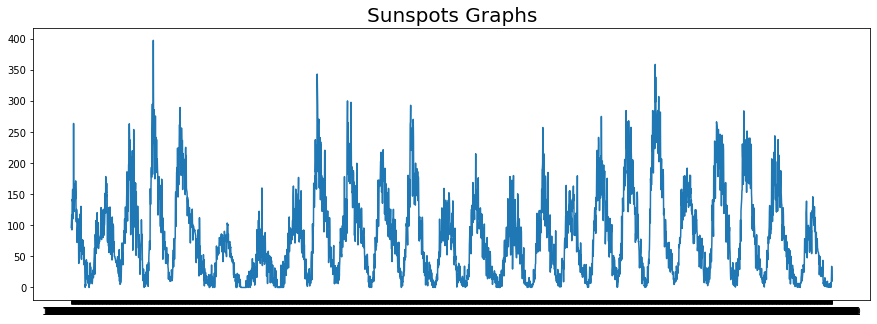

In [10]:
#membuat grafik timeseries
dates = df['Date'].values
spot  = df['Monthly Mean Total Sunspot Number'].values
 
 
plt.figure(figsize=(15,5))
plt.plot(dates, spot)
plt.title('Sunspots Graphs',
          fontsize=20);

In [126]:
#train datanya dengan ukuran 0.2
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(dates,spot, test_size=0.2, random_state=0, shuffle=False)

In [127]:
#cek hasil split
print(len(train_data))
print(len(test_data))

2612
653


In [128]:
train_data

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
...,...,...
2607,1966-04-30,69.0
2608,1966-05-31,64.2
2609,1966-06-30,67.7
2610,1966-07-31,80.2


In [129]:
test_data

,Date,Monthly Mean Total Sunspot Number
2612,1966-09-30,71.1
2613,1966-10-31,81.2
2614,1966-11-30,81.0
2615,1966-12-31,99.8
2616,1967-01-31,157.0
...,...,...
3260,2020-09-30,0.6
3261,2020-10-31,14.4
3262,2020-11-30,34.0
3263,2020-12-31,21.8


In [137]:
#format yang dapat diterima oleh model. Fungsi di bawah menerima sebuah series/atribut kita yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [146]:
#hidden layer yang digunakan lstm dan dropout
train_set = windowed_dataset(Y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
val_set = windowed_dataset(Y_test, window_size=20, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [147]:
#callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')< min_mae):
      print("\nmae telah mencapai <10%!")
      self.model.stop_training = True
callbacks = myCallback()

In [148]:
#menentukan nilai mae
min_mae = (df['Monthly Mean Total Sunspot Number'].max() - df['Monthly Mean Total Sunspot Number'].min()) *0.1
min_mae

39.82

In [153]:
#optimizer dan model fit
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,validation_data=val_set, epochs=200, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/200
26/26 [==============================] - 7s 136ms/step - loss: 79.7825 - mae: 80.2711 - val_loss: 85.1127 - val_mae: 85.6091
Epoch 2/200
26/26 [==============================] - 3s 102ms/step - loss: 79.5177 - mae: 80.0053 - val_loss: 84.8864 - val_mae: 85.3809
Epoch 3/200
26/26 [==============================] - 3s 102ms/step - loss: 79.3608 - mae: 79.8499 - val_loss: 84.7745 - val_mae: 85.2677
Epoch 4/200
26/26 [==============================] - 3s 101ms/step - loss: 79.2073 - mae: 79.6974 - val_loss: 84.6113 - val_mae: 85.1034
Epoch 5/200
26/26 [==============================] - 3s 104ms/step - loss: 79.0303 - mae: 79.5218 - val_loss: 84.4251 - val_mae: 84.9164
Epoch 6/200
26/26 [==============================] - 3s 101ms/step - loss: 78.8202 - mae: 79.3127 - val_loss: 84.1739 - val_mae: 84.6655
Epoch 7/200
26/26 [==============================] - 3s 102ms/step - loss: 78.5520 - mae: 79.0465 - val_loss: 83.8601 - val_mae: 84.3524
Epoch 8/200
26/26 [======================

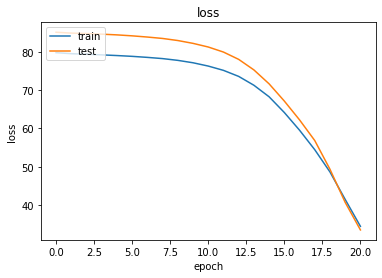

In [155]:
#membuat plot loss model
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

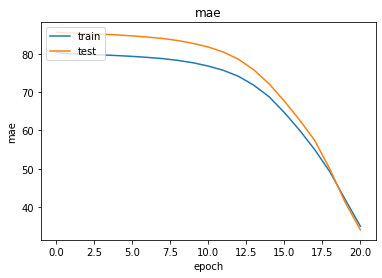

In [156]:
#membuat plot mae model
import matplotlib.pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()